# 酒店評論數據 : 情感性分析
* 數據來源  : https://github.com/SophonPlus/ChineseNlpCorpus/blob/master/datasets/ChnSentiCorp_htl_all/intro.ipynb

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf

from sklearn.utils import shuffle
from train import IMetric, TrainBase
from tensorflow.keras.utils import to_categorical
from processor import DataLoader
from transformers import BertTokenizer
from tqdm import tqdm
tf.autograph.set_verbosity(0)

In [2]:
data = pd.read_csv('sensitive.csv')
data = data.rename(columns={'review': 'content'})
data = data.dropna(0).reset_index(drop=True)
# shuffle the data
data = shuffle(data)
data.head(10)

,label,content
1150,1,"2008.4.5入住该酒店南楼大床间,总体感觉不错，符合三星标准。值得赞一下的是客房送餐很好..."
622,1,房间还算可以，就是旧了些。早餐没有酸奶，有些美中不足。
2720,1,很好的酒店，设施和服务都让人满意，就是偏远了一点。
5689,0,不如新开张时候好了，房间的地毯比较脏，网速是很慢的，电视的操作也非常不人性化。淋浴的地漏下水...
4758,1,我们是从银滩的酒店住宿后，搬过来的，所以这个酒店虽然离银滩远点，但是也没觉得什么不便，每天去...
2312,1,周围的环境很好.在房间可以看到大海.普通间很一般.建议住豪华间.价格差不了多少.豪华间非常大...
5402,0,一句话，那是相当的差！这也叫3星，有没有搞错，旅馆水平都没有。大厅倒过得去。房间里面消毒水的...
2336,1,这里虽然房间不大，但是充满温馨；虽然设施不很豪华，但是比较干净；虽然服务人员不多，但是比较细...
3758,1,上个周末又去了河源。这回提前预订了万豪国际酒店2个晚上，酒店真的没有令我们夫妇失望，我们为自...
1868,1,"房间的整洁及服务都不错,人员的训练及接待都很亲切,入住的感觉也很不错"


## 去空值

In [5]:
print(data.info())
print('=' * 30)
data.content.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7765 entries, 1150 to 2585
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    7765 non-null   int64 
 1   content  7765 non-null   object
dtypes: int64(1), object(1)
memory usage: 182.0+ KB
None


0

## * 去除重複標點符號，例如:"你好!!!!!" --> "你好!"
## * 去除跳脫字符與網址

In [6]:
def preprocess_data(context):
    import re
    import numpy
    context = context.strip()
    context = re.sub(r'[\s]+|http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))', "", context)
    context = re.sub(r'([?。,!])\1+', "", context)
    
    return context

data['content'] = data['content'].apply(preprocess_data)

### 正負樣本比例

      label
1  0.685383
0  0.314617


<AxesSubplot:>

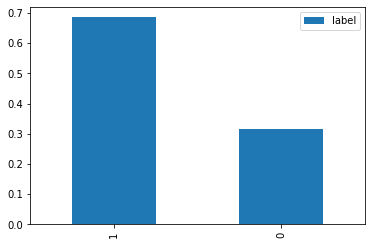

In [7]:
value_count = pd.DataFrame(data.label.value_counts(normalize=True))
print(value_count)
print('=' * 20)
value_count.plot.bar()

### 字數統計

<AxesSubplot:title={'center':'neg'}, ylabel='Frequency'>

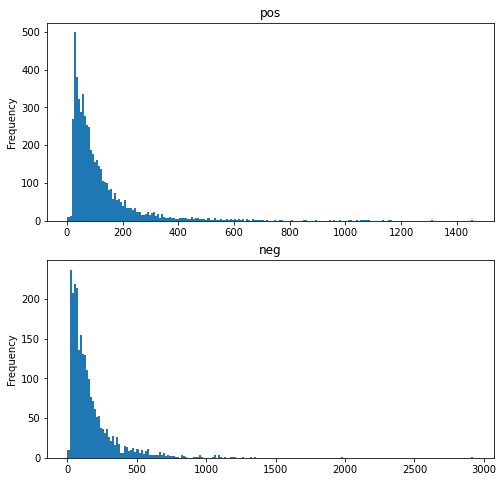

In [8]:
pos_len = data[data.label == 1].content.apply(len)
neg_len = data[data.label == 0].content.apply(len)
pos_len.name, neg_len.name = 'pos_content', 'neg_content'
fig, axs = plt.subplots(2, figsize=(8,8))

pos_len.plot.hist(ax=axs[0], title='pos',bins=200)
neg_len.plot.hist(ax=axs[1], title='neg', bins=200)

In [9]:
pd.concat([pos_len.describe(), neg_len.describe()], 1)

,pos_content,neg_content
count,5322.000000,2443.000000
mean,111.867531,163.998363
std,119.109333,180.723843
min,2.000000,2.000000
25%,42.000000,57.000000
50%,75.000000,108.000000
75%,135.750000,201.000000
max,1459.000000,2924.000000


In [10]:
count = 200
print(f'正向文字小於{count}字的比例 : ',  len(pos_len[pos_len <= count]) / len(pos_len))
print(f'負向文字小於{count}字的比例 : ',  len(neg_len[neg_len <= count]) / len(neg_len))

正向文字小於200字的比例 :  0.8703494926719278
負向文字小於200字的比例 :  0.7490790012279983


## Split data into train and test

In [11]:
split_point = int(len(data) * 0.8)
train_data = data.iloc[:split_point]
test_data = data.iloc[split_point:]
train_data.to_pickle('./data/train_data/train.pickle')
test_data.to_pickle('./data/test_data/test.pickle')

In [12]:
train_data

,label,content
1150,1,"2008.4.5入住该酒店南楼大床间,总体感觉不错，符合三星标准。值得赞一下的是客房送餐很好..."
622,1,房间还算可以，就是旧了些。早餐没有酸奶，有些美中不足。
2720,1,很好的酒店，设施和服务都让人满意，就是偏远了一点。
5689,0,不如新开张时候好了，房间的地毯比较脏，网速是很慢的，电视的操作也非常不人性化。淋浴的地漏下水...
4758,1,我们是从银滩的酒店住宿后，搬过来的，所以这个酒店虽然离银滩远点，但是也没觉得什么不便，每天去...
...,...,...
5029,1,位置好是没得说的，酒店比较老旧了，宽带有的还要收费。
5779,0,千万不要住！首先是走廊和房间都一股发霉的味道！而且早餐超级难吃！最受不了的就是招待所级别的服...
2848,1,房间很一般，但服务员态度还不错。不过听说韶山还有比这个更好的酒店，但携程没有。免费注册网站导...
3767,1,免费自助早餐在该酒店斜对面的阳光.和酒巴.这个酒巴可是被用来拍过电影的哦.


#  Basic Train
* 用roberta model 建模

In [2]:
from train import IMetric, TrainBase

from roberta.model import RoBertaFineTune

### Prepare training data

In [3]:
training_data = pd.read_pickle('./data/train_data/train.pickle')
split_spot = int(training_data.shape[0] * 0.8)
train = training_data.iloc[: split_spot]
validation = training_data.iloc[split_spot: ]

tokenizer = BertTokenizer.from_pretrained("hfl/chinese-roberta-wwm-ext")
train_BTL = DataLoader(data=train,
                      MAX_SEQUENCE_LENGTH=200,
                      batch_size=10,
                      imbalance_sample=False,
                      tokenizer=tokenizer)

val_BTL = DataLoader(data=validation, 
                     MAX_SEQUENCE_LENGTH=200,
                     batch_size=10, 
                     imbalance_sample=False,
                     tokenizer=tokenizer)

In [4]:
model = RoBertaFineTune(False)


# Define customized metrics

In [3]:
class Metrics(IMetric):

    def __init__(self):
        self.f1 = tfa.metrics.F1Score(num_classes=2, name='f1_score')
        self.acc_metric = tf.keras.metrics.CategoricalAccuracy()
        self.AUC = tf.keras.metrics.AUC()
        self.recall_neg = tf.keras.metrics.Recall(class_id=0)
        

    def calculate_metric(self, y_batch, logits):
        self.f1(to_categorical(y_batch, 2), logits)
        self.AUC(to_categorical(y_batch, 2), logits)
        self.acc_metric(to_categorical(y_batch, 2), logits)
        self.recall_neg(to_categorical(y_batch, 2), logits)
        
        
    @property
    def get_result(self):
        result = dict()
        for name, metric in self.__dict__.items():
            result_metric =  metric.result()
            
            try:
                #get the f1 score of label=1 
                result[name] = result_metric[1]
            except:
                
                result[name] = result_metric
           
                

        return result
        

In [6]:
class RegularTrain(TrainBase):
    def __init__(self, model, metric: Metrics):
        self.model = model
        self.metric = metric

    def train_step(self, X_batch, y_batch, optimizer, loss_recoder):
        with tf.GradientTape() as tape:
            logits = self.model(X_batch)

            loss_value = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_batch, logits)

            loss_recoder.append(loss_value.numpy())

        grads = tape.gradient(loss_value, self.model.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        return logits, loss_recoder

    def setting_optimizer(self, decay_steps):
        bert_lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[200, 600, 1200], 
                                                                                values=[2e-5, 1.5e-5, 1.5e-5*0.5, 1.5e-5*0.25])

        optimizer = tf.keras.optimizers.Adam(learning_rate=bert_lr_schedule)
        
        
        return optimizer


In [7]:
RegularTrain(model=model, metric=Metrics).start_to_train(train_data_loader=train_BTL, 
                                                         epochs=10,
                                                         checkpoint_path='./roberta/roberta_checkpoint',
                                                         tensorboard_path={'train':f'./roberta/tensorboard/train_roberta', 'validation': f'./roberta/tensorboard/val_roberta'},
                                                         validation_data_loader=val_BTL)

  0%|          | 0/497 [00:00<?, ?it/s]

tf.Tensor(2e-05, shape=(), dtype=float32)
EPOCH 0


100%|██████████| 497/497 [02:26<00:00,  3.39it/s]


training loss is 0.2808985334092103
Training f1 over epoch : 0.9118639230728149
Training acc_metric over epoch : 0.8790501356124878
Training AUC over epoch : 0.9519521594047546
Training recall_neg over epoch : 0.7938209176063538


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4346630754470825
Validation f1 over epoch : 0.9291167259216309
Validation acc_metric over epoch : 0.8954142928123474
Validation AUC over epoch : 0.9640759229660034
Validation recall_neg over epoch : 0.6978609561920166
tf.Tensor(1.5e-05, shape=(), dtype=float32)
EPOCH 1


100%|██████████| 497/497 [02:21<00:00,  3.52it/s]


training loss is 0.12333092446180371
Training f1 over epoch : 0.9649978280067444
Training acc_metric over epoch : 0.9523043036460876
Training AUC over epoch : 0.9906920194625854
Training recall_neg over epoch : 0.9237074255943298


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.40674857449531554
Validation f1 over epoch : 0.926943302154541
Validation acc_metric over epoch : 0.8994368314743042
Validation AUC over epoch : 0.9634386897087097
Validation recall_neg over epoch : 0.8689839839935303
tf.Tensor(7.5e-06, shape=(), dtype=float32)
EPOCH 2


100%|██████████| 497/497 [02:21<00:00,  3.52it/s]


training loss is 0.042889907979546955
Training f1 over epoch : 0.9893396496772766
Training acc_metric over epoch : 0.9855101704597473
Training AUC over epoch : 0.9981029629707336
Training recall_neg over epoch : 0.9810844659805298


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.40178678107261656
Validation f1 over epoch : 0.9329545497894287
Validation acc_metric over epoch : 0.9050683975219727
Validation AUC over epoch : 0.954018235206604
Validation recall_neg over epoch : 0.8128342032432556
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 3


100%|██████████| 497/497 [02:21<00:00,  3.52it/s]


training loss is 0.012705948108145957
Training f1 over epoch : 0.9980778098106384
Training acc_metric over epoch : 0.9973837733268738
Training AUC over epoch : 0.9994565844535828
Training recall_neg over epoch : 0.99684739112854


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4065815036296844
Validation f1 over epoch : 0.9299588203430176
Validation acc_metric over epoch : 0.9042638540267944
Validation AUC over epoch : 0.9464107751846313
Validation recall_neg over epoch : 0.893048107624054
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 4


100%|██████████| 497/497 [02:21<00:00,  3.50it/s]


training loss is 0.009766046751483336
Training f1 over epoch : 0.9988173246383667
Training acc_metric over epoch : 0.9983900189399719
Training AUC over epoch : 0.9993181824684143
Training recall_neg over epoch : 0.998108446598053


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.42195936799049377
Validation f1 over epoch : 0.9248492121696472
Validation acc_metric over epoch : 0.8897827863693237
Validation AUC over epoch : 0.9308144450187683
Validation recall_neg over epoch : 0.7032085657119751
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 5


100%|██████████| 497/497 [02:25<00:00,  3.42it/s]


training loss is 0.006028795582836099
Training f1 over epoch : 0.9991129636764526
Training acc_metric over epoch : 0.9987925291061401
Training AUC over epoch : 0.9997633099555969
Training recall_neg over epoch : 0.9987389445304871


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.40342419815063474
Validation f1 over epoch : 0.9347198605537415
Validation acc_metric over epoch : 0.9090909361839294
Validation AUC over epoch : 0.9439977407455444
Validation recall_neg over epoch : 0.8582887649536133
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 6


100%|██████████| 497/497 [02:23<00:00,  3.46it/s]


training loss is 0.003562494547185556
Training f1 over epoch : 0.9995564222335815
Training acc_metric over epoch : 0.9993962645530701
Training AUC over epoch : 0.9997895359992981
Training recall_neg over epoch : 1.0


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4047931437492371
Validation f1 over epoch : 0.9341728687286377
Validation acc_metric over epoch : 0.9074819087982178
Validation AUC over epoch : 0.9379903078079224
Validation recall_neg over epoch : 0.8342245817184448
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 7


100%|██████████| 497/497 [02:22<00:00,  3.49it/s]


training loss is 0.002425921021695579
Training f1 over epoch : 0.9997043609619141
Training acc_metric over epoch : 0.9995974898338318
Training AUC over epoch : 0.9999945163726807
Training recall_neg over epoch : 1.0


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4056369104385376
Validation f1 over epoch : 0.9331810474395752
Validation acc_metric over epoch : 0.9058728814125061
Validation AUC over epoch : 0.9348610639572144
Validation recall_neg over epoch : 0.8262032270431519
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 8


100%|██████████| 497/497 [02:22<00:00,  3.48it/s]


training loss is 0.0014508650234984271
Training f1 over epoch : 0.9997043609619141
Training acc_metric over epoch : 0.9995974898338318
Training AUC over epoch : 0.9999997615814209
Training recall_neg over epoch : 1.0


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4063283474445343
Validation f1 over epoch : 0.9332572817802429
Validation acc_metric over epoch : 0.9058728814125061
Validation AUC over epoch : 0.934385359287262
Validation recall_neg over epoch : 0.8235294222831726
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 9


100%|██████████| 497/497 [02:22<00:00,  3.48it/s]


training loss is 0.0005463649436600283
Training f1 over epoch : 0.9998522400856018
Training acc_metric over epoch : 0.9997987747192383
Training AUC over epoch : 0.9999999403953552
Training recall_neg over epoch : 1.0
 loss of validation is 0.4075393044948578
Validation f1 over epoch : 0.9332572817802429
Validation acc_metric over epoch : 0.9058728814125061
Validation AUC over epoch : 0.930372416973114
Validation recall_neg over epoch : 0.8235294222831726


# Train with data agumentation

### data agument --> back translate

### Prepare training data

In [4]:
training_data = pd.read_pickle('./data/train_data/train.pickle')
split_spot = int(training_data.shape[0] * 0.8)
train = training_data.iloc[: split_spot]
validation = training_data.iloc[split_spot: ]

back_translate_data = pd.read_pickle('./data/augment_data/back_translate_data.pkl').iloc[: split_spot]
back_translate_data_train = pd.DataFrame(back_translate_data['back_translate']).rename(columns={'back_translate':'content'})

In [5]:
back_translate_data

,content,back_translate
0,"2008.4.5入住该酒店南楼大床间,总体感觉不错，符合三星标准。值得赞一下的是客房送餐很好...",2008.4.5从南汇大号床房间开始，整体感觉很好，符合三星标准。房间很好，食物很好，价格不...
1,房间还算可以，就是旧了些。早餐没有酸奶，有些美中不足。,房间仍然可以，它很老。早餐没有酸奶，美丽有一点。
2,很好的酒店，设施和服务都让人满意，就是偏远了一点。,非常好的酒店，设施和服务很满意，它很远。
3,不如新开张时候好了，房间的地毯比较脏，网速是很慢的，电视的操作也非常不人性化。淋浴的地漏下水...,有一个新的开口更好，房间的地毯更脏，速度很慢，电视的运作非常稳定。淋浴的地板流失很慢，你将不...
4,我们是从银滩的酒店住宿后，搬过来的，所以这个酒店虽然离银滩远点，但是也没觉得什么不便，每天去...,在宾坦的酒店住宿后，我们搬家了，所以这家酒店虽然这家酒店离Yintan很远，但它并不是任何不...
...,...,...
4964,"两个月里面已经住了三次了,当然好啦,交通也很方便哈",它已经在两个月内生活了三次。当然，交通也很方便。
4965,"物有所值,但其预定车票的服务太一般,我给他们商务中心要求订次日到西安的卧铺票,除要收我30元...",有钱，但预订机票的服务太一般，我会问他们的商业中心订购睡眠机票到西安，除了收集我30元的门票...
4966,入住的酒店设施有点老，电视机也不较小，跟500元的房价还是有点差距的，不过服务不错，当天还送...,酒店的设施有点老，电视不小，价格500元仍然有点差距，但服务很好，生日鲜花和水果已被发送。
4967,房间小得不像话，早餐差得不像话，绝对不会再光顾。隔壁的南国大酒店看上去不错。晚上想在酒店的餐...,房间不喜欢，早餐是不可移开的，它永远不会再次光顾。南中国宾馆隔壁看起来很好。我想在酒店的餐厅...


In [6]:

tokenizer = BertTokenizer.from_pretrained("hfl/chinese-roberta-wwm-ext")
train_BTL = DataLoader(data=train,
                      MAX_SEQUENCE_LENGTH=200,
                      batch_size=10,
                      imbalance_sample=False,
                      tokenizer=tokenizer)

val_BTL = DataLoader(data=validation, 
                     MAX_SEQUENCE_LENGTH=200,
                     batch_size=10, 
                     imbalance_sample=False,
                     tokenizer=tokenizer)

back_translate_BTL = DataLoader(data=back_translate_data_train, 
                     MAX_SEQUENCE_LENGTH=200,
                     batch_size=10, 
                     imbalance_sample=False,
                     tokenizer=tokenizer,
                     mode='no label')

### Overriding the 'start_to_train' method

In [7]:
import math
from tqdm import tqdm
from train import TensorBoard
class BackTranslationTrain(TrainBase):
    def __init__(self, model, metric: Metrics):
        self.model = model
        self.metric = metric
        self.back_translation_yielder = None
        
    def train_step(self, X_batch, y_batch, optimizer, loss_recoder):
        with tf.GradientTape() as tape:
            logits = self.model(X_batch)
            data_batch = next(iter(self.back_translation_yielder))
            back_translate_x_batch = data_batch[0:3]
#             print( back_translate_x_batch)

            crossentropy_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_batch, logits)
            kl_loss = self._calculate_KLDivergence_loss_for_back_translation(X_batch_logits=logits, back_translate_x_batch=back_translate_x_batch)
            
            _lambda = 1 
            loss_value = crossentropy_loss + (_lambda * kl_loss)

            loss_recoder.append(loss_value.numpy())

        grads = tape.gradient(loss_value, self.model.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        return logits, loss_recoder
    
    def setting_optimizer(self, decay_steps):
        bert_lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[200, 600, 1200], 
                                                                                values=[2e-5, 1.5e-5, 1.5e-5*0.5, 1.5e-5*0.25])


        optimizer = tf.keras.optimizers.Adam(learning_rate=bert_lr_schedule)
        return optimizer
    
    
    def start_to_train(self, train_data_loader,
                   epochs,
                   checkpoint_path,
                   tensorboard_path: dict,
                   back_translation_data_loader,
                   validation_data_loader=None,
                   ):

        BATCH_LENGHT = math.ceil(train_data_loader.data.shape[0] / train_data_loader.batch_size)

        # saving manager
        checkpoint = tf.train.Checkpoint(Model=self.model)
        #         manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_path, max_to_keep=10)

        # Initialize Metric
        TrainMetric = self.metric()

        writer = tf.summary.create_file_writer(tensorboard_path['train'])

        optimizer = self.setting_optimizer(decay_steps=epochs)
        for epoch in range(epochs):
            print(optimizer.lr(optimizer.iterations))
            print('==========================')
            print(f'EPOCH {epoch}')
            print('==========================')

            loss_recoder = []

            #             tf.summary.trace_on(graph=True)
            self.back_translation_yielder = self._yield_back_translation_btl(back_translation_data_loader)
            for step, (X_batch_train, y_batch_train) in tqdm(enumerate(train_data_loader), total=BATCH_LENGHT):
                logits, loss_recoder = self.train_step(X_batch=X_batch_train,
                                                       y_batch=y_batch_train,
                                                       optimizer=optimizer,
                                                       loss_recoder=loss_recoder)

                TrainMetric.calculate_metric(y_batch_train, logits=logits)
                if step % 500 == 0:
                    #                     manager.save(checkpoint_number=step)
                    checkpoint.save(f'{checkpoint_path}/ckpt-epoch:{epoch}')

            epoch_loss = sum(loss_recoder) / len(loss_recoder)

            print(f"training loss is {epoch_loss}")

            for name, result in TrainMetric.get_result.items():
                print(f'Training {name} over epoch : {float(result)}')
            print('============================================================')

            #             with writer.as_default():
            #                 tf.summary.trace_export(name="my_trace",step=0)

            TrainTB = TensorBoard(writer=writer,
                                  model=self.model)
            TrainTB.start_to_write(metrics_result=TrainMetric.get_result,
                                   step=epoch,
                                   loss=epoch_loss,
                                   histogram=True,
                                   optimizer=optimizer)

            TrainMetric.reset()

            if validation_data_loader is not None:
                self._validation(validation_data_loader=validation_data_loader,
                                 val_logdir=tensorboard_path['validation'],
                                 ep=epoch)

    
    
    def _yield_back_translation_btl(self, back_translation_data: DataLoader): 
        yield from back_translation_data
        
    def _calculate_KLDivergence_loss_for_back_translation(self, X_batch_logits, back_translate_x_batch):
        back_translate_x_logits = self.model(back_translate_x_batch)
        kl_loss = tf.keras.losses.KLDivergence()(X_batch_logits, back_translate_x_logits)
        return kl_loss

In [8]:
model = RoBertaFineTune(False)


In [9]:
BackTranslationTrain(model=model, metric=Metrics).start_to_train(train_data_loader=train_BTL, 
                                                                 epochs=10,
                                                                 checkpoint_path='./roberta/back_translate_roberta_checkpoint',
                                                                 tensorboard_path={'train':f'./roberta/tensorboard/back_translate_train_roberta', 'validation': f'./roberta/tensorboard/back_translate_val_roberta'},
                                                                 validation_data_loader=val_BTL, 
                                                                 back_translation_data_loader=back_translate_BTL)

  0%|          | 0/497 [00:00<?, ?it/s]

tf.Tensor(2e-05, shape=(), dtype=float32)
EPOCH 0


100%|██████████| 497/497 [04:24<00:00,  1.88it/s]


training loss is 0.32279402358641085
Training f1 over epoch : 0.9118416905403137
Training acc_metric over epoch : 0.8780438899993896
Training AUC over epoch : 0.9516432881355286
Training recall_neg over epoch : 0.7749054431915283


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.44497132205963136
Validation f1 over epoch : 0.919241189956665
Validation acc_metric over epoch : 0.8801287412643433
Validation AUC over epoch : 0.9625219106674194
Validation recall_neg over epoch : 0.6577540040016174
tf.Tensor(1.5e-05, shape=(), dtype=float32)
EPOCH 1


100%|██████████| 497/497 [04:20<00:00,  1.91it/s]


training loss is 0.17507077957797698
Training f1 over epoch : 0.9616180062294006
Training acc_metric over epoch : 0.9476755857467651
Training AUC over epoch : 0.9889150261878967
Training recall_neg over epoch : 0.9155107140541077


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4036319115161896
Validation f1 over epoch : 0.9365351796150208
Validation acc_metric over epoch : 0.9106999039649963
Validation AUC over epoch : 0.9734562039375305
Validation recall_neg over epoch : 0.8368983864784241
tf.Tensor(7.5e-06, shape=(), dtype=float32)
EPOCH 2


100%|██████████| 497/497 [04:20<00:00,  1.90it/s]


training loss is 0.10171894184936782
Training f1 over epoch : 0.9835872054100037
Training acc_metric over epoch : 0.9776614904403687
Training AUC over epoch : 0.9972517490386963
Training recall_neg over epoch : 0.9659520983695984


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.39806857895851133
Validation f1 over epoch : 0.9393592476844788
Validation acc_metric over epoch : 0.9147224426269531
Validation AUC over epoch : 0.9726678133010864
Validation recall_neg over epoch : 0.8449198007583618
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 3


100%|██████████| 497/497 [04:21<00:00,  1.90it/s]


training loss is 0.05513910051005175
Training f1 over epoch : 0.9926057457923889
Training acc_metric over epoch : 0.9899376034736633
Training AUC over epoch : 0.9993218183517456
Training recall_neg over epoch : 0.9854981303215027


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.39719184017181397
Validation f1 over epoch : 0.939841091632843
Validation acc_metric over epoch : 0.9147224426269531
Validation AUC over epoch : 0.9618579745292664
Validation recall_neg over epoch : 0.8262032270431519
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 4


100%|██████████| 497/497 [04:20<00:00,  1.91it/s]


training loss is 0.03278229786093643
Training f1 over epoch : 0.9965991377830505
Training acc_metric over epoch : 0.9953712821006775
Training AUC over epoch : 0.9998517036437988
Training recall_neg over epoch : 0.9936948418617249


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4017903203964233
Validation f1 over epoch : 0.9332585334777832
Validation acc_metric over epoch : 0.9042638540267944
Validation AUC over epoch : 0.9509866833686829
Validation recall_neg over epoch : 0.7807486653327942
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 5


100%|██████████| 497/497 [04:21<00:00,  1.90it/s]


training loss is 0.02688418328855749
Training f1 over epoch : 0.9965941309928894
Training acc_metric over epoch : 0.9953712821006775
Training AUC over epoch : 0.9995049238204956
Training recall_neg over epoch : 0.99684739112854


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.40112661027908325
Validation f1 over epoch : 0.9354295134544373
Validation acc_metric over epoch : 0.9074819087982178
Validation AUC over epoch : 0.9598324298858643
Validation recall_neg over epoch : 0.7887700796127319
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 6


100%|██████████| 497/497 [04:21<00:00,  1.90it/s]


training loss is 0.016319553798641515
Training f1 over epoch : 0.9989643692970276
Training acc_metric over epoch : 0.9985912442207336
Training AUC over epoch : 0.9999467134475708
Training recall_neg over epoch : 1.0


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4003491623401642
Validation f1 over epoch : 0.9340278506278992
Validation acc_metric over epoch : 0.9082863926887512
Validation AUC over epoch : 0.9494669437408447
Validation recall_neg over epoch : 0.8609625697135925
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 7


100%|██████████| 497/497 [04:21<00:00,  1.90it/s]


training loss is 0.015373936723394205
Training f1 over epoch : 0.9983725547790527
Training acc_metric over epoch : 0.997786283493042
Training AUC over epoch : 0.9999648928642273
Training recall_neg over epoch : 0.9987389445304871


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.4041948118209839
Validation f1 over epoch : 0.9352112412452698
Validation acc_metric over epoch : 0.9074819087982178
Validation AUC over epoch : 0.9450134634971619
Validation recall_neg over epoch : 0.7967914342880249
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 8


100%|██████████| 497/497 [04:21<00:00,  1.90it/s]


training loss is 0.016986253091789524
Training f1 over epoch : 0.9989643692970276
Training acc_metric over epoch : 0.9985912442207336
Training AUC over epoch : 0.9995525479316711
Training recall_neg over epoch : 1.0


  0%|          | 0/497 [00:00<?, ?it/s]

 loss of validation is 0.40345853447914126
Validation f1 over epoch : 0.9346330165863037
Validation acc_metric over epoch : 0.9082863926887512
Validation AUC over epoch : 0.9524235129356384
Validation recall_neg over epoch : 0.8395721912384033
tf.Tensor(3.75e-06, shape=(), dtype=float32)
EPOCH 9


100%|██████████| 497/497 [04:26<00:00,  1.86it/s]


training loss is 0.019947449752116497
Training f1 over epoch : 0.9982248544692993
Training acc_metric over epoch : 0.9975849986076355
Training AUC over epoch : 0.9999719262123108
Training recall_neg over epoch : 0.998108446598053
 loss of validation is 0.406131187915802
Validation f1 over epoch : 0.9315849542617798
Validation acc_metric over epoch : 0.903459370136261
Validation AUC over epoch : 0.9440962076187134
Validation recall_neg over epoch : 0.8181818127632141


## Testing

In [10]:
import numpy as np
from time import time
from sklearn.metrics import classification_report


In [11]:
tokenizer = BertTokenizer.from_pretrained("hfl/chinese-roberta-wwm-ext")

test = pd.read_pickle('./data/test_data/test.pickle')

In [12]:
def calcuate_test_loss(y_pred_logitis, y_true):
#     y_true = [y_true.map({'negative':1, 'positive':0}).iloc[0]]
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_true, y_pred_logitis)
    return loss

def predict(model, test_data):
    y_pred_li, y_pred_logitis_li, pooler_out_li = [], [], []
    predict_loss = []
    for i in range(0, len(test_data), 1):
        data = test_data.iloc[i : i + 1]

        pred_BTL = DataLoader(data=data ,
                         MAX_SEQUENCE_LENGTH=200,
                         batch_size=len(data), 
                         imbalance_sample=False,
                         tokenizer=tokenizer)

        y_pred, y_pred_logitis, pooler_out  = model.predict(pred_BTL, model=model, return_logistis_and_pooler=True)
        predict_loss.append(calcuate_test_loss(y_pred_logitis, test_data.iloc[i : i + 1]['label']))
        y_pred_li.extend(list(y_pred.numpy()))
        y_pred_logitis_li.extend(list(y_pred_logitis.numpy().max(-1)))
        pooler_out_li.append(pooler_out.numpy())
    return y_pred_li, y_pred_logitis_li, pooler_out_li, predict_loss
    
from sklearn.metrics import classification_report
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## General roberta

In [13]:
%%time
general_roberta = RoBertaFineTune(False).load_model('./roberta/roberta_checkpoint/', latest=True)
y_pred_li, y_pred_logitis_li, pooler_out_li, predict_loss = predict(general_roberta, test)

.....model is loading
You got it
CPU times: user 2min 15s, sys: 912 ms, total: 2min 15s
Wall time: 2min 25s


In [19]:
# tf.saved_model.save(general_roberta, './roberta/general_roberta_model')

### predict loss

<AxesSubplot:ylabel='Frequency'>

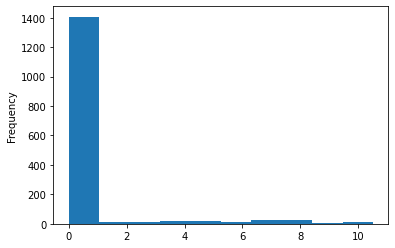

In [14]:
pd.Series([i.numpy() for i in predict_loss]).plot(kind='hist')


              precision    recall  f1-score   support

         neg       0.84      0.84      0.84       483
         pos       0.93      0.93      0.93      1070

    accuracy                           0.90      1553
   macro avg       0.89      0.89      0.89      1553
weighted avg       0.90      0.90      0.90      1553

Confusion matrix, without normalization
[[408  75]
 [ 77 993]]


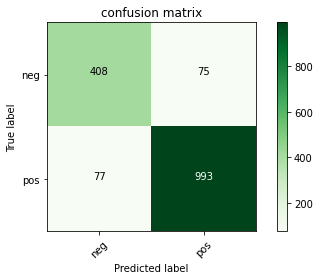

In [15]:
y_true = test.label
print(classification_report(y_true, y_pred_li, target_names=['neg', 'pos']))
cnf_matrix = confusion_matrix(y_true, y_pred_li)
plot_confusion_matrix(cnf_matrix, classes=['neg', 'pos'],normalize=False,
                    title='confusion matrix')

## Back translate roberta

In [16]:
%%time
translate_roberta =  RoBertaFineTune(False).load_model('./roberta/back_translate_roberta_checkpoint', latest=True)
y_translate_pred_li, y_translate_pred_logitis_li, pooler_translate_out_li, predict_translate_loss = predict(translate_roberta, test)

.....model is loading
You got it
CPU times: user 1min 48s, sys: 899 ms, total: 1min 49s
Wall time: 2min


In [20]:
# tf.saved_model.save(translate_roberta, './roberta/back_translate_roberta_model')

### predict loss

<AxesSubplot:ylabel='Frequency'>

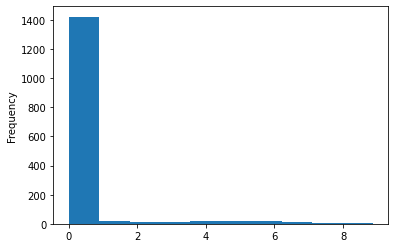

In [17]:
pd.Series([i.numpy() for i in predict_translate_loss]).plot(kind='hist')


              precision    recall  f1-score   support

         neg       0.85      0.88      0.87       483
         pos       0.95      0.93      0.94      1070

    accuracy                           0.91      1553
   macro avg       0.90      0.91      0.90      1553
weighted avg       0.92      0.91      0.91      1553

Confusion matrix, without normalization
[[427  56]
 [ 77 993]]


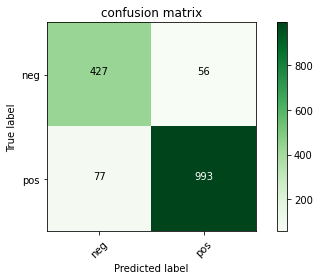

In [18]:
y_true = test.label
print(classification_report(y_true, y_translate_pred_li, target_names=['neg', 'pos']))
cnf_matrix = confusion_matrix(y_true, y_translate_pred_li)
plot_confusion_matrix(cnf_matrix, classes=['neg', 'pos'],normalize=False,
                    title='confusion matrix')